In [1]:
import torch
import numpy as np
from torch import nn
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import torch
from torch import nn
from src.utils import imgutils, torchutils

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, first_stride, first_dilation_padding, dilation_padding):
        super(ResBlock, self).__init__()

        self.same_shape = (in_channels == out_channels)

        self.bn_branch2a = nn.BatchNorm2d(num_features=in_channels)
        self.relu_branch2a = nn.ReLU()
        self.conv_branch2a = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, stride=first_stride, padding=first_dilation_padding, dilation=first_dilation_padding, bias=False)

        self.bn_branch2b1 = nn.BatchNorm2d(num_features=mid_channels)
        self.relu_branch2b1 = nn.ReLU()
        self.conv_branch2b1 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=dilation_padding, dilation=dilation_padding, bias=False)

        if not self.same_shape:
            self.conv_branch1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=first_stride, bias=False)

    def forward(self, x):

        branch2 = self.bn_branch2a(x)
        branch2 = self.relu_branch2a(branch2)

        x_bn_relu = branch2

        if not self.same_shape:
            branch1 = self.conv_branch1(branch2)
        else:
            branch1 = x

        branch2 = self.conv_branch2a(branch2)

        branch2 = self.bn_branch2b1(branch2)
        branch2 = self.relu_branch2b1(branch2)
        branch2 = self.conv_branch2b1(branch2)

        x = branch2 + branch1

        return x, x_bn_relu

In [4]:
class ResBlockBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_padding=1, dropout=0.0):
        super(ResBlockBottleneck, self).__init__()

        self.same_shape = (in_channels == out_channels)

        self.bn_branch2a = nn.BatchNorm2d(num_features=in_channels)
        self.relu_branch2a = nn.ReLU()
        self.conv_branch2a = nn.Conv2d(in_channels=in_channels, out_channels=out_channels // 4, kernel_size=1, bias=False)

        self.bn_branch2b1 = nn.BatchNorm2d(num_features=out_channels // 4)
        self.relu_branch2b1 = nn.ReLU()
        self.conv_branch2b1 = nn.Conv2d(in_channels=out_channels // 4, out_channels=out_channels // 2, kernel_size=3, padding=dilation_padding, dilation=dilation_padding, bias=False)

        self.bn_branch2b2 = nn.BatchNorm2d(num_features=out_channels // 2)
        self.relu_branch2b2 = nn.ReLU()
        self.dropout_branch2b2 = nn.Dropout2d(p=dropout)
        self.conv_branch2b2 = nn.Conv2d(in_channels=out_channels // 2, out_channels=out_channels, kernel_size=1, bias=False)

        if not self.same_shape:
            self.conv_branch1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)

    def forward(self, x):

        branch2 = self.bn_branch2a(x)
        branch2 = self.relu_branch2a(branch2)

        x_bn_relu = branch2

        if not self.same_shape:
            branch1 = self.conv_branch1(branch2)
        else:
            branch1 = x

        branch2 = self.conv_branch2a(branch2)

        branch2 = self.bn_branch2b1(branch2)
        branch2 = self.relu_branch2b1(branch2)
        branch2 = self.conv_branch2b1(branch2)

        branch2 = self.bn_branch2b2(branch2)
        branch2 = self.relu_branch2b2(branch2)
        branch2 = self.conv_branch2b2(branch2)

        x = branch1 + branch2

        return x, x_bn_relu

In [6]:
class ResNet38ClassificationModel(nn.Module):
    def __init__(self):
        super(ResNet38ClassificationModel, self).__init__()

        self.enable_PDA = False
        self.mu = 1
        self.gamma = 0

        self.conv1a = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)

        #  -------- B1 -----------#
        # Input size = (224, 224),
        # So no B1 layer

        # -------- B2 -----------#
        self.res2a = ResBlock(in_channels=64, mid_channels=128, out_channels=128, first_stride=2, first_dilation_padding=1, dilation_padding=1)
        self.res2b1 = ResBlock(in_channels=128, mid_channels=128, out_channels=128, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res2b2 = ResBlock(in_channels=128, mid_channels=128, out_channels=128, first_stride=1, first_dilation_padding=1, dilation_padding=1)

        # -------- B3 -----------#
        self.res3a = ResBlock(in_channels=128, mid_channels=256, out_channels=256, first_stride=2, first_dilation_padding=1, dilation_padding=1)
        self.res3b1 = ResBlock(in_channels=256, mid_channels=256, out_channels=256, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res3b2 = ResBlock(in_channels=256, mid_channels=256, out_channels=256, first_stride=1, first_dilation_padding=1, dilation_padding=1)

        # -------- B4 -----------#
        self.res4a = ResBlock(in_channels=256, mid_channels=512, out_channels=512, first_stride=2, first_dilation_padding=1, dilation_padding=1)
        self.res4b1 = ResBlock(in_channels=512, mid_channels=512, out_channels=512, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res4b2 = ResBlock(in_channels=512, mid_channels=512, out_channels=512, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res4b3 = ResBlock(in_channels=512, mid_channels=512, out_channels=512, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res4b4 = ResBlock(in_channels=512, mid_channels=512, out_channels=512, first_stride=1, first_dilation_padding=1, dilation_padding=1)
        self.res4b5 = ResBlock(in_channels=512, mid_channels=512, out_channels=512, first_stride=1, first_dilation_padding=1, dilation_padding=1)

        # -------- B5 -----------#
        self.res5a = ResBlock(in_channels=512, mid_channels=512, out_channels=1024, first_stride=1, first_dilation_padding=1, dilation_padding=2)
        self.res5b1 = ResBlock(in_channels=1024, mid_channels=512, out_channels=1024, first_stride=1, first_dilation_padding=2, dilation_padding=2)
        self.res5b2 = ResBlock(in_channels=1024, mid_channels=512, out_channels=1024, first_stride=1, first_dilation_padding=2, dilation_padding=2)

        # -------- B6 -----------#
        self.res6a = ResBlockBottleneck(in_channels=1024, out_channels=2048, dilation_padding=4, dropout=0.3)

        # -------- B7 -----------#
        self.res7a = ResBlockBottleneck(in_channels=2048, out_channels=4096, dilation_padding=4, dropout=0.5)
        self.bn7 = nn.BatchNorm2d(num_features=4096)
        self.relu7 = nn.ReLU()
        # -----------------------#

        self.dropout = nn.Dropout2d(p=0.5)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc8 = nn.Conv2d(in_channels=4096, out_channels=4, kernel_size=1, bias=False)

        nn.init.xavier_uniform_(tensor=self.fc8.weight)
        self.not_training = [self.conv1a, self.res2a, self.res2b1, self.res2b2]
        self.from_scratch_layers = [self.fc8]

    def extract_features(self, imgs):

        x = self.conv1a(imgs)  # (b, 64, 224, 224)

        # -------- B2 -----------#
        x, x1a = self.res2a(x=x)  # (b, 128, 112, 112), (b, 64, 224, 224)
        x, x2a = self.res2b1(x=x)  # (b, 128, 112, 112), (b, 128, 112, 112)
        x, x2b1 = self.res2b2(x=x)  # (b, 128, 112, 112), (b, 128, 112, 112)

        # -------- B3 -----------#
        # (b, 256, 56, 56), (b, 128, 112, 112)
        x, x2b2 = self.res3a(x=x)
        # (b, 256, 56, 56), (b, 256, 56, 56)
        x, x3a = self.res3b1(x=x)
        # (b, 256, 56, 56), (b, 256, 56, 56)
        x, x3b1 = self.res3b2(x=x)

        # -------- B4 -----------#
        # (b, 512, 28, 28), (b, 256, 56, 56)
        x, x3b2 = self.res4a(x=x)
        # (b, 512, 28, 28), (b, 512, 28, 28)
        x, x4a = self.res4b1(x=x)
        # (b, 512, 28, 28), (b, 512, 28, 28)
        x, x4b1 = self.res4b2(x=x)
        # (b, 512, 28, 28), (b, 512, 28, 28)
        x, x4b2 = self.res4b3(x=x)
        # (b, 512, 28, 28), (b, 512, 28, 28)
        x, x4b3 = self.res4b4(x=x)
        # (b, 512, 28, 28), (b, 512, 28, 28)
        x, x4b4 = self.res4b5(x=x)

        # -------- B5 -----------#
        # (b, 1024, 28, 28), (b, 512, 28, 28)
        x, x4b5 = self.res5a(x=x)
        # (b, 1024, 28, 28), (b, 1024, 28, 28)
        x, x5a = self.res5b1(x=x)
        # (b, 1024, 28, 28), (b, 1024, 28, 28)
        x, x5b1 = self.res5b2(x=x)

        # -------- B6 -----------#
        # (b, 2048, 28, 28), (b, 1024, 28, 28)
        x, x5b2 = self.res6a(x=x)

        # -------- B7 -----------#
        # (b, 4096, 28, 28), (b, 2048, 28, 28)
        x, x6a = self.res7a(x=x)
        x = self.bn7(x)  # (b, 4096, 28, 28)
        x = self.relu7(x)  # (b, 4096, 28, 28)
        # -----------------------#

        return {
            'x1a': x1a,

            'x2a': x2a,
            'x2b1': x2b1,
            'x2b2': x2b2,

            'x3a': x3a,
            'x3b1': x3b1,
            'x3b2': x3b2,

            'x4a': x4a,
            'x4b1': x4b1,
            'x4b2': x4b2,
            'x4b3': x4b3,
            'x4b4': x4b4,
            'x4b5': x4b5,

            'x5a': x5a,
            'x5b1': x5b1,
            'x5b2': x5b2,

            'x6a': x6a,

            'x7a': x
        }

    def make_multiscale_cam(self, x):  # (b, 3, 224, 224)
        with torch.no_grad():
            x7a = self.extract_features(imgs=x)['x7a']  # (b, 4096, 28, 28)
            cam28 = torch.conv2d(input=x7a, weight=self.fc8.weight)  # (b, 4, 28, 28)
            cam28 = torch.relu(input=cam28)
            cam224 = F.interpolate(input=cam28, size=(224, 224), mode='bilinear', align_corners=False)
        return cam224  # {'camS': (b, 4, S, S), ...}

    def forward(self, x):
        if self.enable_PDA:
            cam = self.make_multiscale_cam(x=x)
            x = init_forward_PDA(img=x, cam=cam, mu=self.mu)
            mmd = x.clone().detach().cpu()
            plt.imshow(mmd.moveaxis(1, -1)[0])
            plt.show()

        x = self.extract_features(imgs=x)['x7a']  # (b, 4096, 28, 28)

        if self.enable_PDA:
            x = final_forward_PDA(x=x, w=self.fc8.weight, mu=self.mu, gamma=self.gamma)

        x = self.dropout(x)  # (b, 4096, 28, 28)
        x = self.avgpool(x)  # (b, 4096, 1, 1)
        x = self.fc8(x)  # (b, 4, 1, 1)

        return x  # (b, 4, 1, 1)

    def forward_cam(self, x):  # (b, 3, 224, 224)
        x = self.extract_features(imgs=x)['x7a']  # (b, 4096, 28, 28)

        cam = torch.conv2d(input=x, weight=self.fc8.weight)  # (b, 4, 28, 28)
        cam = torch.relu(input=cam)  # (b, 4, 28, 28)

        z = self.avgpool(x)  # (b, 4096, 1, 1)
        z = self.fc8(z)  # (b, 4, 1, 1)
        z = torch.sigmoid(input=z)  # (b, 4, 1, 1)

        return cam, z  # (b, 4, 28, 28), (b, 4, 1, 1)

    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for m in self.modules():

            if isinstance(m, nn.Conv2d):

                if m.weight.requires_grad:
                    if m in self.from_scratch_layers:
                        groups[2].append(m.weight)
                    else:
                        groups[0].append(m.weight)

                if m.bias is not None and m.bias.requires_grad:
                    if m in self.from_scratch_layers:
                        groups[3].append(m.bias)
                    else:
                        groups[1].append(m.bias)

        return groups

    def train(self, mode=True):
        super(ResNet38ClassificationModel, self).train(mode)

        for layer in self.not_training:

            if isinstance(layer, nn.Conv2d):
                layer.weight.requires_grad = False

            elif isinstance(layer, nn.Module):
                for c in layer.children():
                    if hasattr(c, 'weight'):
                        c.weight.requires_grad = False
                    if hasattr(c, 'bias'):
                        if c.bias is not None:
                            c.bias.requires_grad = False

        for layer in self.modules():

            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()
                layer.bias.requires_grad = False
                layer.weight.requires_grad = False


In [7]:
def get_mask(cam, bg):

    cam = imgutils.interpolate(cam, 224)
    cam = torchutils.standard_scale(cam, dims=-3)
    cam = imgutils.put_palette(cam, bg)

    return cam

In [8]:
def stack_vis(img, bg, vis_cams, gt_mask, gt_title, pred_titles):

    fig = plt.figure(figsize=(30, 5 * len(vis_cams)))
    columns = 7
    rows = len(vis_cams)

    i = 0
    for j, c in enumerate(vis_cams):
        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.grid(visible=False)

        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(c[0, 0])
        plt.colorbar()
        plt.grid(visible=False)

        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(c[0, 1])
        plt.colorbar()
        plt.grid(visible=False)

        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(c[0, 2])
        plt.colorbar()
        plt.grid(visible=False)

        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(c[0, 3])
        plt.colorbar()
        plt.grid(visible=False)

        i += 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(gt_mask)
        plt.colorbar()
        plt.title(f'GT {str(gt_title)}')
        plt.grid(visible=False)

        i += 1
        mask = get_mask(c, bg)
        fig.add_subplot(rows, columns, i)
        plt.imshow(mask)
        plt.colorbar()
        plt.title(f'{str(pred_titles[j])}')
        plt.grid(visible=False)

    plt.show()

In [9]:
img1 = Image.open(fp='datasets/LUAD-HistoSeg/val/img/385277-44539-46781.png')
# img2 = Image.open(fp='test/data/1031280-4988-14480-[1 0 0 1].png')
img1 = T.ToTensor()(img1).unsqueeze(0)
# img2 = T.ToTensor()(img2).unsqueeze(0)
# img = torch.cat(tensors=(img1, img2), dim=0)
img = img1.to(device=device)
mask = Image.open(fp='datasets/LUAD-HistoSeg/val/mask/385277-44539-46781.png')
mask = mask.convert(mode='P')
RED = [205, 51, 51]
GREEN = [0, 255, 0]
BLUE = [65, 105, 225]
ORANGE = [255, 165, 0]
WHITE = [255, 255, 255]
mask.putpalette(data=RED + GREEN + BLUE + ORANGE + WHITE)

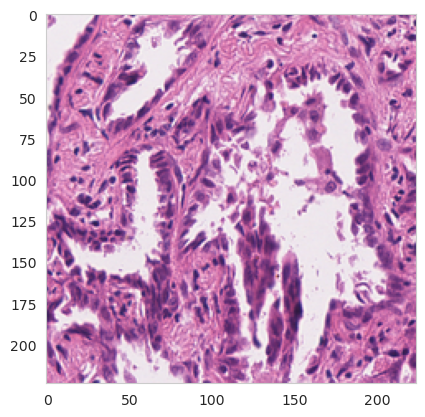

In [12]:
plt.imshow(img.moveaxis(1, -1)[0])
plt.grid(visible=False)
plt.show()

In [13]:
model = ResNet38ClassificationModel()
model.load_state_dict(
    state_dict=torch.load(
        f='test/Base6/weights/Base6_E3_checkpoint_trained_on_luad.pth'
    )['model_state_dict']
)
model = model.to(device=device)
model.eval()

In [15]:
feat = model.extract_features(imgs=img)
feat = {k: v.detach().cpu() for k, v in feat.items()}
w = model.fc8.weight.detach().cpu()

In [16]:
feat.keys()

dict_keys(['x1a', 'x2a', 'x2b1', 'x2b2', 'x3a', 'x3b1', 'x3b2', 'x4a', 'x4b1', 'x4b2', 'x4b3', 'x4b4', 'x4b5', 'x5a', 'x5b1', 'x5b2', 'x6a', 'x7a'])

In [21]:
cam28 = torch.conv2d(input=feat['x7a'], weight=w)
cam28 = torch.relu(input=cam28)

beta = torch.amax(input=cam28, dim=(-2, -1), keepdim=True) * 0.65  # (b, num_classes, 1, 1)
beta = beta.expand(size=cam28.size())  # (b, num_classes, h, w)

cam = torch.less(input=cam28, other=beta) * cam28  # (b, num_classes, h, w)

cam = cam.mean(dim=1, keepdim=True) > 0  # (b, 1, h, w)
cam28 = cam28 * cam
cam224bicubic = F.interpolate(input=cam28, size=(224, 224), mode='bicubic', align_corners=False)
cam224bilinear = F.interpolate(input=cam28, size=(224, 224), mode='bilinear', align_corners=False)

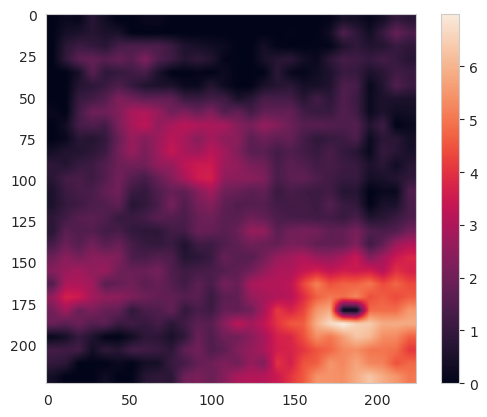

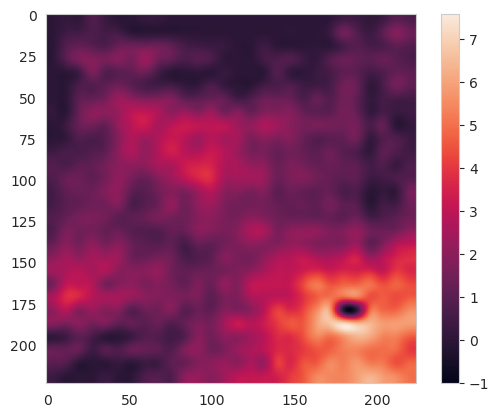

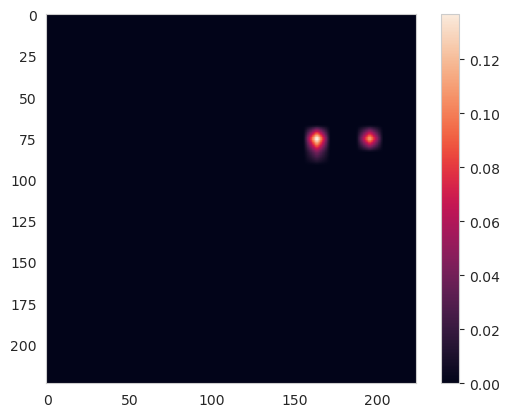

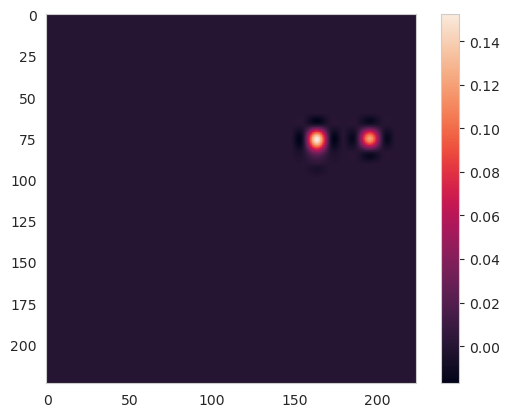

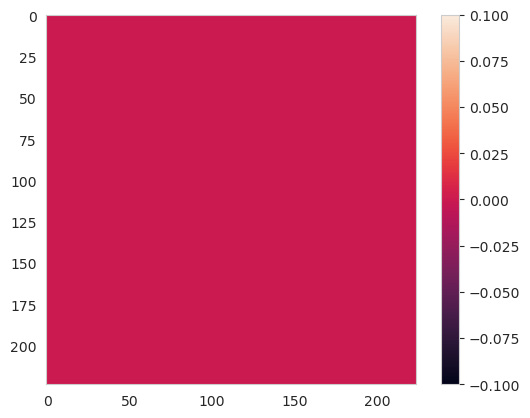

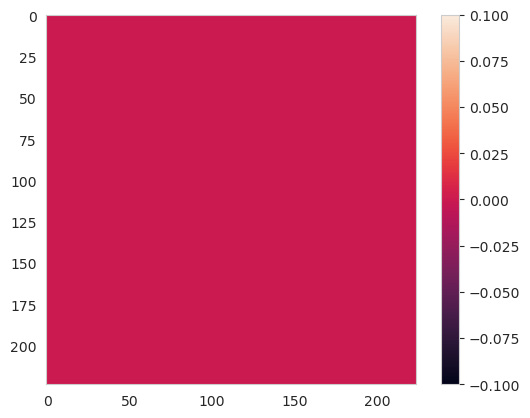

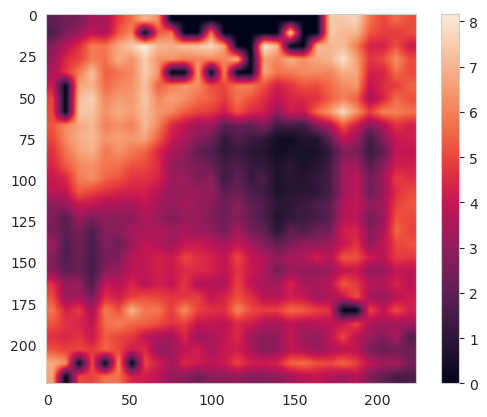

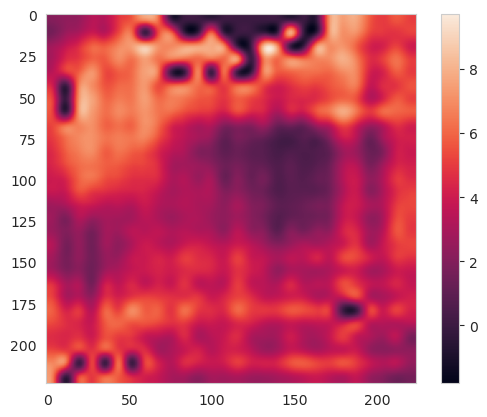

In [22]:
for i in range(4):
    plt.imshow(cam224bilinear[0, i])
    plt.grid(visible=False)
    plt.colorbar()
    plt.show()

    plt.imshow(cam224bicubic[0, i])
    plt.grid(visible=False)
    plt.colorbar()
    plt.show()

In [ ]:
z56 = feat['x3b2'].mean(dim=1, keepdim=True) * cam56 * bg56
z112 = feat['x2b2'].mean(dim=1, keepdim=True) * cam112 * bg112
zz28 = intermediate_forward_PDA(x=feat['x7a'], cam=cam28, bg=bg28)
zz56 = intermediate_forward_PDA(x=feat['x3b2'], cam=cam56, bg=bg56)
zz112 = intermediate_forward_PDA(x=feat['x2b2'], cam=cam112, bg=bg112)

In [ ]:
stack_vis(
    img=img.moveaxis(1, -1)[0].detach().cpu(),
    bg=1-bg224,
    vis_cams=[cam28, z56, z112, zz28, zz56, zz112],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam28', 'cam56', 'cam112', 'zz28', 'zz56', 'zz112']
)

In [ ]:
tmp = 'x3b2'
plt.imshow(feat[tmp].mean(dim=1, keepdim=True)[0, 0].detach().cpu())
plt.colorbar()
plt.show()

z = feat[tmp].mean(dim=1, keepdim=True) * cam56
for i in range(4):
    plt.matshow(img[0].moveaxis(0, -1).detach().cpu())
    plt.show()

    plt.imshow(mask)
    plt.show()

    plt.matshow(z[0, i].detach().cpu())
    plt.colorbar()
    plt.show()


In [ ]:
tmp = 'x3b2'
plt.matshow((feat[tmp].mean(dim=1, keepdim=True)*bg56)[0, 0].detach().cpu())
plt.colorbar()
plt.show()

z = intermediate_forward_PDA(x=feat[tmp], cam=cam56, bg=bg56)
for i in range(4):
    plt.matshow(img[0].moveaxis(0, -1).detach().cpu())
    plt.show()

    plt.matshow(mask)
    plt.show()

    plt.matshow(z[0, i].detach().cpu())
    plt.colorbar()
    plt.show()

z = feat[tmp] * z
plt.matshow(z.mean(dim=1, keepdim=True))
plt.show()

In [ ]:
def sns_cams(x, title='Untitled', annot=True, figsize=(20, 20)):
    for i in range(x.size(1)):
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.heatmap(data=x[0, i], annot=annot, ax=ax)
        plt.title(f'{title} {i}')
        plt.show()

In [ ]:
img_name = '396367-16626-28119.png'
val_path = 'datasets/LUAD-HistoSeg/val'
trans = T.Compose([T.ToTensor()])
img = Image.open(fp=f'{val_path}/img/{img_name}')
img = trans(img).unsqueeze(0)
mask = Image.open(fp=f'{val_path}/mask/{img_name}')

bg = imgutils.get_backgrounds(names=None, images=img[0], save_path=None)  # (224, 224)
bg = np.expand_dims(bg, axis=(0, 1))

In [ ]:
device = torch.device('cpu')
# device = torch.device('cpu')
model = ResNet38ClassificationModel(num_classes=4)
# cv = {
#     'conv1a.': 'conv1a.',
#     'b2.': 'res2a.',
#     'b2_1.': 'res2b1.',
#     'b2_2.': 'res2b2.',
#     'b3.': 'res3a.',
#     'b3_1.': 'res3b1.',
#     'b3_2.': 'res3b2.',
#     'b4.': 'res4a.',
#     'b4_1.': 'res4b1.',
#     'b4_2.': 'res4b2.',
#     'b4_3.': 'res4b3.',
#     'b4_4.': 'res4b4.',
#     'b4_5.': 'res4b5.',
#     'b5.': 'res5a.',
#     'b5_1.': 'res5b1.',
#     'b5_2.': 'res5b2.',
#     'b6.': 'res6a.',
#     'b7.': 'res7a.',
#     'bn7.': 'bn7.',
#     'fc8.': 'fc8.',
# }
# w = torch.load(f='init_weights/stage1_checkpoint_trained_on_luad.pth', map_location='cpu')
# new_w = {}
# for kcv, vcv in cv.items():
#     for kw, vw in w.items():
#         if kw.startswith(kcv):
#             new_k = vcv + kw[len(kcv):]
#             new_w[new_k] = vw

# model.load_state_dict(
#     state_dict=new_w,
#     strict=False
# )
model.load_state_dict(
    state_dict=torch.load(
        f='checkpoints/MMD2/weights/MMD2_E4_checkpoint_trained_on_luad.pth'
    )['model_state_dict']
)

model = model.to(device)
model.eval()

In [ ]:
model.enable_PDA = False
f = model.extract_features(x=img.to(device))

model.mu = [2 for _ in range(15)]
model.gamma = [0 for _ in range(15)]
model.enable_PDA = True
cams = model.make_multiscale_cam(x=img.to(device)) if model.enable_PDA else None
f2 = model.extract_features(x=img.to(device), enable_PDA=model.enable_PDA, cams=cams)  # (b, 4096, 56, 56)

In [ ]:
for k in f.keys():
    print(f'{k}: {f[k].size()}, {f[k].min()}, {f[k].max()} | {f2[k].size()}, {f2[k].min()}, {f2[k].max()}')

In [ ]:
x1a, f1a = f['x1a'].detach().cpu(), f2['x1a'].detach().cpu()
x2a, f2a = f['x2a'].detach().cpu(), f2['x2a'].detach().cpu()
x2b1, f2b1 = f['x2b1'].detach().cpu(), f2['x2b1'].detach().cpu()
x2b2, f2b2 = f['x2b2'].detach().cpu(), f2['x2b2'].detach().cpu()
x3a, f3a = f['x3a'].detach().cpu(), f2['x3a'].detach().cpu()
x3b1, f3b1 = f['x3b1'].detach().cpu(), f2['x3b1'].detach().cpu()
x3b2, f3b2 = f['x3b2'].detach().cpu(), f2['x3b2'].detach().cpu()
x4a, f4a = f['x4a'].detach().cpu(), f2['x4a'].detach().cpu()
x4b1, f4b1 = f['x4b1'].detach().cpu(), f2['x4b1'].detach().cpu()
x4b2, f4b2 = f['x4b2'].detach().cpu(), f2['x4b2'].detach().cpu()
x4b3, f4b3 = f['x4b3'].detach().cpu(), f2['x4b3'].detach().cpu()
x4b4, f4b4 = f['x4b4'].detach().cpu(), f2['x4b4'].detach().cpu()
x4b5, f4b5 = f['x4b5'].detach().cpu(), f2['x4b5'].detach().cpu()
x5a, f5a = f['x5a'].detach().cpu(), f2['x5a'].detach().cpu()
x5b1, f5b1 = f['x5b1'].detach().cpu(), f2['x5b1'].detach().cpu()
x5b2, f5b2 = f['x5b2'].detach().cpu(), f2['x5b2'].detach().cpu()
x6a, f6a = f['x6a'].detach().cpu(), f2['x6a'].detach().cpu()
x7a, f7a = f['x7a'].detach().cpu(), f2['x7a'].detach().cpu()
weight = model.fc8.weight.detach().cpu()

In [ ]:
cam = torch.conv2d(input=x7a, weight=weight)
cam = torch.relu(input=cam)
camf = torch.conv2d(input=f7a, weight=weight)
camf = torch.relu(input=camf)

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam, camf],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam', 'camf']
)

In [ ]:
# tmp = torch.mean(input=x1a, dim=1, keepdim=True)
# sns_cams(x=tmp, annot=False, title='TMP Mean')
#
# sns_cams(x=cams['cam224'], annot=False, title='CAMS')
#
# tmp = tmp * cams['cam224']
# sns_cams(x=tmp, annot=False, title='TMP * CAMS')
#
# maxs = torch.amax(input=tmp, dim=(-2, -1), keepdim=True) * 0.7  # (b, num_classes, 1, 1)
# mins = (torch.amin(input=tmp, dim=(-2, -1), keepdim=True) + 1e-9) * 0.2
# maxs = maxs.expand(size=tmp.size())  # (b, num_classes, h, w)
# mins = mins.expand(size=tmp.size())  # (b, num_classes, h, w)
# tmp = torch.less(input=tmp, other=maxs) * torch.greater(input=tmp, other=mins) * tmp  # (b, num_classes, h, w)
# sns_cams(x=tmp, annot=False, title='REDUCED')
#
# tmp = torch.mean(input=tmp, dim=1, keepdim=True)  # (b, 1, h, w)
# out = x1a * tmp  # (b, c, h, w)
#
# sns_cams(x=out.mean(dim=1, keepdim=True), annot=False, title='REDUCED MEAN')

In [ ]:
sns_cams(x=cams['cam224'].mean(dim=1, keepdim=True), annot=False)

In [ ]:
print(x4b5.min(), x4b5.max())
print(x4b5.mean(dim=1).min(), x4b5.mean(dim=1).max())
sns_cams(x=x4b5.mean(dim=1, keepdim=True))
beta = torch.amax(input=x4b5, dim=(-2, -1), keepdim=True)
tmp = torch.less(input=x4b5, other=beta) * x4b5
sns_cams(x=tmp.mean(dim=1, keepdim=True))

In [ ]:
a4 = F.max_pool2d(x4, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a4_1 = F.max_pool2d(x4_1, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a4_2 = F.max_pool2d(x4_2, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a4_3 = F.max_pool2d(x4_3, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a4_4 = F.max_pool2d(x4_4, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a4_5 = F.max_pool2d(x4_5, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a5 = F.max_pool2d(x5, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a5_1 = F.max_pool2d(x5_1, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a5_2 = F.max_pool2d(x5_2, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
a6 = F.max_pool2d(x6, kernel_size=3, stride=1, padding=1, dilation=1).sum(dim=1, keepdim=True)
cam2 = x7 + a4 + a4_1 + a4_2 + a4_3 + a4_4 + a4_5 + a5 + a5_1 + a5_2 + a6
cam2 = torch.conv2d(input=cam2, weight=weight)
cam2 = torch.relu(input=cam2)
cam2 = cam2 - torch.sum(input=cam, dim=1, keepdim=True) + cam
cam2 = torch.relu(input=cam2)

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam, cam2],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam', 'cam2']
)

In [ ]:
plt.matshow((a4 + a4_1)[0, 0])
plt.colorbar()
plt.show()

In [ ]:
plt.matshow((a4[0] + a5[0] + a6[0])[0])
plt.colorbar()
plt.show()

In [ ]:
maxs = torch.amax(input=cam, dim=(-2, -1), keepdim=True) + 1e-5
cam2 = torch.relu(input=cam - 1e-5) / maxs
cam2[:, 0, :, :] = 1 - torch.amax(input=cam2[:, 1:, :, :], dim=1, keepdim=True)
maxs = torch.amax(input=cam2[:, 1:, :, :], dim=1, keepdim=True)
cam2[:, 1:, :, :][cam2[:, 1:, :, :] < maxs] = 0
print(cam2.size())

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam, cam2],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam', 'cam2']
)

In [ ]:
tmpcam = F.interpolate(input=cam, size=(112, 112), mode='bilinear', align_corners=False)
tmp2_2 = torch.relu(input=x2_2)
tmp3_2 = F.interpolate(input=torch.relu(input=x3_2), size=(112, 112), mode='bilinear', align_corners=False)
tmp4_5 = F.interpolate(input=torch.relu(input=x4_5), size=(112, 112), mode='bilinear', align_corners=False)
tmp5_2 = F.interpolate(input=torch.relu(input=x5_2), size=(112, 112), mode='bilinear', align_corners=False)
tmp6 = F.interpolate(input=torch.relu(input=x6), size=(112, 112), mode='bilinear', align_corners=False)
x_s = F.interpolate(input=img, size=(112, 112), mode='bilinear', align_corners=False)
cam3 = torch.cat(tensors=[tmp2_2, tmp3_2, tmp4_5, tmp5_2, tmp6, x_s], dim=1)
cam3 = cam3.view(cam3.size(0), cam3.size(1), -1)
cam3 = cam3 / (torch.norm(input=cam3, dim=1, keepdim=True) + 1e-5)
cam3 = torch.matmul(input=cam3.transpose(-2, -1), other=cam3)
cam3 = torch.relu(input=cam3)
cam3 = cam3 / (torch.sum(input=cam3, dim=1, keepdim=True) + 1e-5)
cam3 = torch.matmul(input=tmpcam.view(tmpcam.size(0), tmpcam.size(1), -1), other=cam3)
cam3 = cam3.reshape(cam3.size(0), cam3.size(1), 112, 112)
cam3 = torchutils.standard_scale(x=cam3, dims=-2)
print(cam3.size())

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam, cam2, cam3],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam', 'cam2', 'cam3']
)

In [ ]:
cam4 = x7 + x5_2.mean(dim=1, keepdim=True) + x4_5.mean(dim=1, keepdim=True)
cam4 = torch.conv2d(input=cam4, weight=weight)
cam4 = torch.relu(input=cam4)

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam4],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam4']
)

In [ ]:
cam5 = x7 + x5_2.mean(dim=1, keepdim=True) + x4_5.mean(dim=1, keepdim=True)  # (b, 4096, 28, 28)

# (b, 4096, 56, 56)
cam5 = F.interpolate(input=cam5, size=(56, 56), mode='bilinear', align_corners=False)
cam5 = cam5 + x3_2.mean(dim=1, keepdim=True)

cam5 = F.interpolate(input=cam5, size=(112, 112), mode='bilinear', align_corners=False)
cam5 = cam5 + x2_2.mean(dim=1, keepdim=True)

cam5 = torch.conv2d(input=cam5, weight=weight)
cam5 = torch.relu(input=cam5)

stack_vis(
    img=img.moveaxis(1, -1)[0],
    bg=bg,
    vis_cams=[cam5],
    gt_mask=mask,
    gt_title=[1, 0, 0, 1],
    pred_titles=['cam5']
)

In [ ]:
plt.matshow(x2_2.mean(dim=1)[0] + x2)
plt.colorbar()